In [1]:
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Set working directory
os.chdir("..") # Go one level up
os.getcwd()

'/Users/miguelibarra/PycharmProjects/cin'

In [3]:
data_folder = os.path.abspath("/Users/miguelibarra/Documents/")
print(data_folder)

/Users/miguelibarra/Documents


In [4]:
# Iterate over datafolder and get which files belong to which well
pathlist = Path(data_folder).rglob('*.czi')
well_file = [[str(path.parent.stem), str(path.stem).replace("Snap-","")] for path in pathlist]
well_file = pd.DataFrame(well_file, columns=["well","file"])
well_file.well.value_counts()

A375 kif2a  + dox    33
A375 + dox           30
A375 dnMCAK + dox    27
A375 kif2c - dox     27
A375 - dox           26
A375 dnMCAK - dox    26
A375 kif2c + dox     24
A375 kif2a - dox     24
Name: well, dtype: int64

In [5]:
# Read predictions
pred_path = os.path.abspath("predictions/predictions_lindsay_all.csv")
pred_df = pd.read_csv(pred_path)
print(pred_df.shape)

# Fix name
pred_df["file"] = pred_df.apply(lambda x: os.path.splitext(x.image.split(" - ")[0].split("_")[0].replace("Snap-",""))[0], axis=1)
pred_df

(2718, 2)


,image,prediction,file
0,Snap-1974.czi - Snap-1974.czi #1.tif_mask.npy_...,0.007155,1974
1,Snap-1974.czi - Snap-1974.czi #1.tif_mask.npy_...,0.017433,1974
2,Snap-1974.czi - Snap-1974.czi #1.tif_mask.npy_...,0.005621,1974
3,Snap-1974.czi - Snap-1974.czi #1.tif_mask.npy_...,0.639256,1974
4,Snap-1974.czi - Snap-1974.czi #1.tif_mask.npy_...,0.004503,1974
...,...,...,...
2713,Snap-2401.czi - Snap-2401.czi #1.tif_mask.npy_...,0.547940,2401
2714,Snap-2401.czi - Snap-2401.czi #1.tif_mask.npy_...,0.498356,2401
2715,Snap-2401.czi - Snap-2401.czi #1.tif_mask.npy_...,0.005049,2401
2716,Snap-2401.czi - Snap-2401.czi #1.tif_mask.npy_...,0.013172,2401


In [6]:
# Counting predicted micro-nuclei per slide/well
threshold = 0.5
predicted_micronuclei_perwell = pd.concat([pd.Series([i, d.shape[0], (d["prediction"] >= threshold).astype(int).sum()]) for i,d in pred_df.groupby("file")], axis=1).T
predicted_micronuclei_perwell = predicted_micronuclei_perwell.rename(columns={0:"file", 1:"cells", 2:"micronuclei"})
predicted_micronuclei_perwell.head()

,file,cells,micronuclei
0,1974,9,3
1,1975,9,1
2,1976,7,1
3,1977,7,4
4,1978,8,3


In [28]:
# Load micro-nuclei per slide
ground_true = pd.read_csv("LC results.csv")
ground_true

,image,micronuclei
0,/Users/lindsaycaprio/Downloads/micronuclei_lab...,0
1,/Users/lindsaycaprio/Downloads/micronuclei_lab...,0
2,/Users/lindsaycaprio/Downloads/micronuclei_lab...,0
3,/Users/lindsaycaprio/Downloads/micronuclei_lab...,0
4,/Users/lindsaycaprio/Downloads/micronuclei_lab...,1
...,...,...
2099,/Users/lindsaycaprio/Downloads/micronuclei_lab...,1
2100,/Users/lindsaycaprio/Downloads/micronuclei_lab...,0
2101,/Users/lindsaycaprio/Downloads/micronuclei_lab...,1
2102,/Users/lindsaycaprio/Downloads/micronuclei_lab...,1


In [8]:
# Fix name
#ground_true["file"] = ground_true["image"].apply(lambda x: os.path.splitext(x.split(" - ")[0].split("_")[0].replace("Snap-",""))[0])
ground_true["file"] = ground_true["image"].apply(lambda x: Path(x).name.split(" - ")[0].split("_")[0].split(".")[0].replace("Snap-", ""))
ground_true = ground_true.sort_values(by="file")
ground_true.head()

,image,micronuclei,file
746,/Users/lindsaycaprio/Downloads/micronuclei_lab...,0,1974
800,/Users/lindsaycaprio/Downloads/micronuclei_lab...,0,1974
1161,/Users/lindsaycaprio/Downloads/micronuclei_lab...,0,1974
248,/Users/lindsaycaprio/Downloads/micronuclei_lab...,1,1974
1346,/Users/lindsaycaprio/Downloads/micronuclei_lab...,0,1974


In [9]:
ground_true = pd.concat([pd.Series([i, d.shape[0], d["micronuclei"].astype(bool).sum()]) for i, d in ground_true.groupby("file")], axis=1).T
ground_true = ground_true.rename(columns={0:"file",1:"cells",2:"micronuclei"})
ground_true.head()

,file,cells,micronuclei
0,1974,9,1
1,1975,9,2
2,1976,7,1
3,1977,7,3
4,1978,8,3


In [10]:
# Merge ground true and predictions
comparable = pd.merge(ground_true, predicted_micronuclei_perwell, on="file", suffixes=["_gt","_pr"])
comparable.head()

,file,cells_gt,micronuclei_gt,cells_pr,micronuclei_pr
0,1974,9,1,9,3
1,1975,9,2,9,1
2,1976,7,1,7,1
3,1977,7,3,7,4
4,1978,8,3,8,3


In [11]:
# Add well information to comparable files
comparable_wells = pd.merge(well_file, comparable, on="file")
comparable_wells.head()

,well,file,cells_gt,micronuclei_gt,cells_pr,micronuclei_pr
0,A375 + dox,1985,11,0,11,2
1,A375 + dox,1991,8,3,8,4
2,A375 + dox,2240,3,1,10,7
3,A375 + dox,1990,10,2,13,6
4,A375 + dox,1984,3,2,3,1


In [12]:
# Check how many files exist per well
well_file.well.value_counts()

A375 kif2a  + dox    33
A375 + dox           30
A375 dnMCAK + dox    27
A375 kif2c - dox     27
A375 - dox           26
A375 dnMCAK - dox    26
A375 kif2c + dox     24
A375 kif2a - dox     24
Name: well, dtype: int64

In [13]:
# Aggregate results by well
aggregated = pd.concat([d.sum()[["cells_gt","cells_pr", "micronuclei_gt", "micronuclei_pr"]].rename(g) for g, d in comparable_wells.groupby("well")], axis=1).T
aggregated = aggregated.reset_index().rename(columns={"index": "well"})

In [14]:
agg_mc = aggregated.melt(id_vars=["well"], value_vars=["micronuclei_gt", "micronuclei_pr"],
                                       var_name="micronuclei_prediction", value_name="micronuclei")
agg_cc = aggregated.melt(id_vars=["well"], value_vars=["cells_gt", "cells_pr"],
                                       var_name="cell_prediction", value_name="cells")

In [15]:
agg_mc["micronuclei_prediction"] = agg_mc["micronuclei_prediction"].apply(lambda x: "predicted" if x.endswith("pr") else "ground_true")
agg_cc["cell_prediction"] = agg_cc["cell_prediction"].apply(lambda x: "predicted" if x.endswith("pr") else "ground_true")

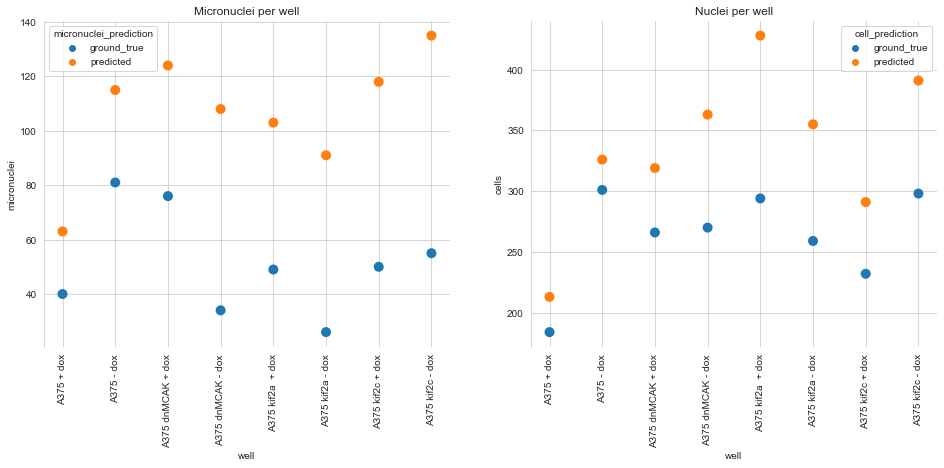

In [16]:
# plot differences
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
sns.scatterplot(data=agg_mc, x="well", y="micronuclei", hue="micronuclei_prediction", s=100, linewidth=0, ax=axs[0])
sns.scatterplot(data=agg_cc, x="well", y="cells", hue="cell_prediction", s=100, linewidth=0, ax=axs[1])
axs[0].set_title("Micronuclei per well")
axs[0].tick_params(axis='x', labelrotation=90)
axs[1].set_title("Nuclei per well")
axs[1].tick_params(axis='x', labelrotation=90)
sns.despine(bottom=True)

In [21]:
agg_cc["ratio"] = agg_cc["cells"]/agg_mc["micronuclei"]

In [23]:
agg_cc

,well,cell_prediction,cells,ratio
0,A375 + dox,ground_true,184,4.6
1,A375 - dox,ground_true,301,3.716049
2,A375 dnMCAK + dox,ground_true,266,3.5
3,A375 dnMCAK - dox,ground_true,270,7.941176
4,A375 kif2a + dox,ground_true,294,6.0
5,A375 kif2a - dox,ground_true,259,9.961538
6,A375 kif2c + dox,ground_true,232,4.64
7,A375 kif2c - dox,ground_true,298,5.418182
8,A375 + dox,predicted,213,3.380952
9,A375 - dox,predicted,326,2.834783


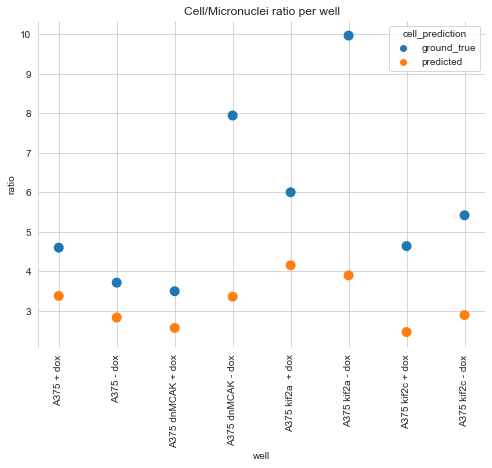

In [27]:
# plot differences
fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
sns.scatterplot(data=agg_cc, x="well", y="ratio", hue="cell_prediction", s=100, linewidth=0, ax=ax)
ax.set_title("Cell/Micronuclei ratio per well")
ax.tick_params(axis='x', labelrotation=90)
sns.despine(bottom=True)